In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Let's load our data we saved from the munging step.
text_file = "hdfs://server:9000/finalRDD.csv"

In [3]:
plays = sc.textFile(text_file)

In [4]:
plays.take(5)

['0,328911829,116947,camo & krooked,2137',
 '13107200,266493556,207956,grouper,517',
 '8912900,821342251,47688,bob marley,424',
 '4718600,444164354,9388,jimmy eat world,81',
 '524300,717350741,17624,ozzy osbourne,74']

In [8]:
_RDD = plays.map(lambda x: (x.split(",")))

In [9]:
_RDD.take(5)

[['0', '328911829', '116947', 'camo & krooked', '2137'],
 ['13107200', '266493556', '207956', 'grouper', '517'],
 ['8912900', '821342251', '47688', 'bob marley', '424'],
 ['4718600', '444164354', '9388', 'jimmy eat world', '81'],
 ['524300', '717350741', '17624', 'ozzy osbourne', '74']]

In [10]:
_RDD.count()

17538292

In [11]:
#find number of artists
artist_count = _RDD.map(lambda x: (x[3])).distinct().count()

In [12]:
print("The number of artists is: {:d}".format(artist_count))

The number of artists is: 287646


In [13]:
# Find the number of users
user_count = _RDD.map(lambda x: (x[1])).distinct().count()

In [14]:
print("The number of users is: {:d}".format(user_count))

The number of users is: 358974


In [15]:
# find the number of entries
number_of_entries = _RDD.count()

In [17]:
print("The number of listener counts is: {:d}".format(number_of_entries))

The number of listener counts is: 17538292


In [18]:
# find the average number of plays
sum_of_ratings = _RDD.map(lambda x: (int(x[4]))).reduce(lambda x,y: x + y)

In [19]:
average_number_of_listens = sum_of_ratings/float(number_of_entries)

In [20]:
print('The average rating is: {:.2f}'.format(average_number_of_listens))

The average rating is: 215.18


In [21]:
print('The largest number of listens is: {:d}'.format(_RDD.map(lambda x:(int(x[4]))).max()))

The largest number of listens is: 419157


In [22]:
print('The smallest number of listens is: {:d}'.format(_RDD.map(lambda x:(int(x[4]))).min()))

The smallest number of listens is: 0


In [66]:
# Let's look at the number of times an artist is rated
rated_number = _RDD.map(lambda x: (x[2])).countByValue()

In [67]:
# Let's look at the number of times an artist is rated
rated_ = []
for item in rated_number.items():
    rated_.append((item[0],item[1]))

In [68]:
rated = sc.parallelize(rated_)

In [89]:
print('The highest-rated artist had : {:d} listens'.format(rated.map(lambda x: (int(x[1]))).max()))

The highest-rated artist had : 77348 listens


In [91]:
print('The average-rated artist had : {:f} listens'.format(rated.map(lambda x: (int(x[1]))).mean()))

The average-rated artist had : 60.971792 listens


In [92]:
print('The lowest-rated artist had : {:d} listens'.format(rated.map(lambda x: (int(x[1]))).min()))

The lowest-rated artist had : 1 listens


In [95]:
#We can see that that we have some values which are going to affect our model.
#It is doubley-clear in the visuals below

In [10]:
rated_num = _RDD.map(lambda x: (float(x[2]))).collect()

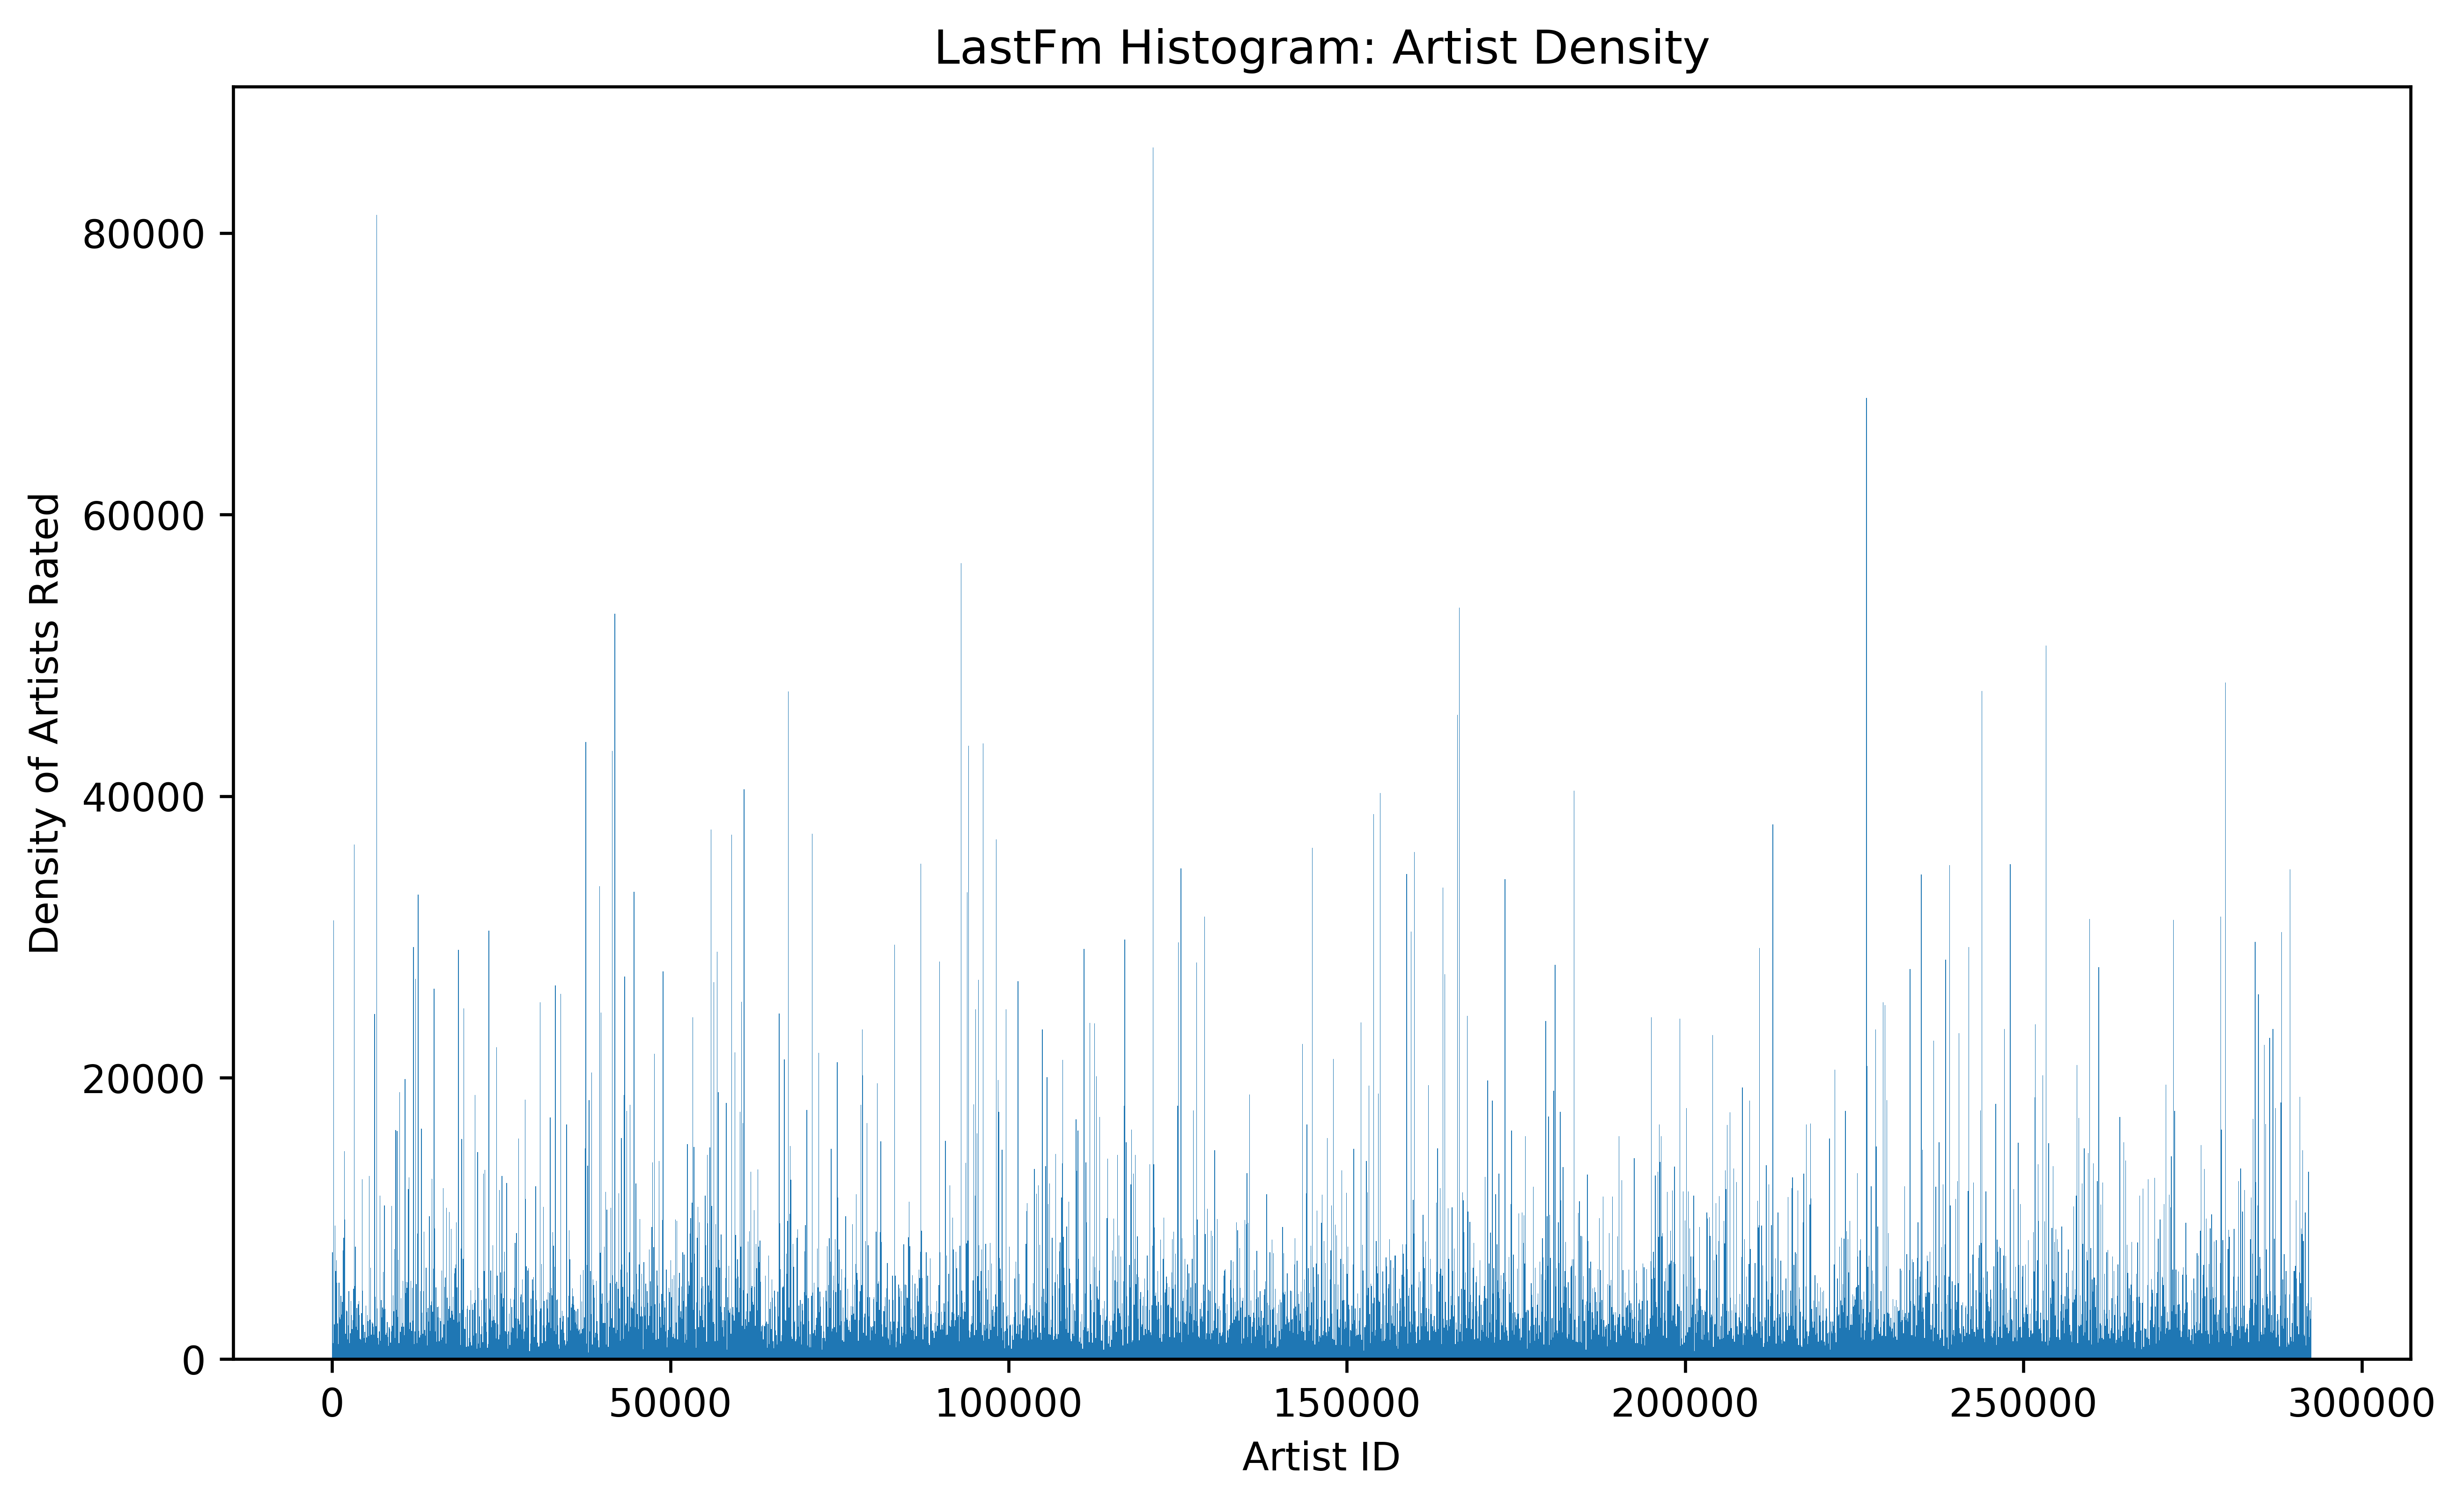

In [11]:
%matplotlib inline
plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x=rated_num,bins=3000,normed=False)

plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')
plt.savefig("lastFMArtBefore.svg")

In [14]:
listens = _RDD.map(lambda x: (float(x[4]))).collect()

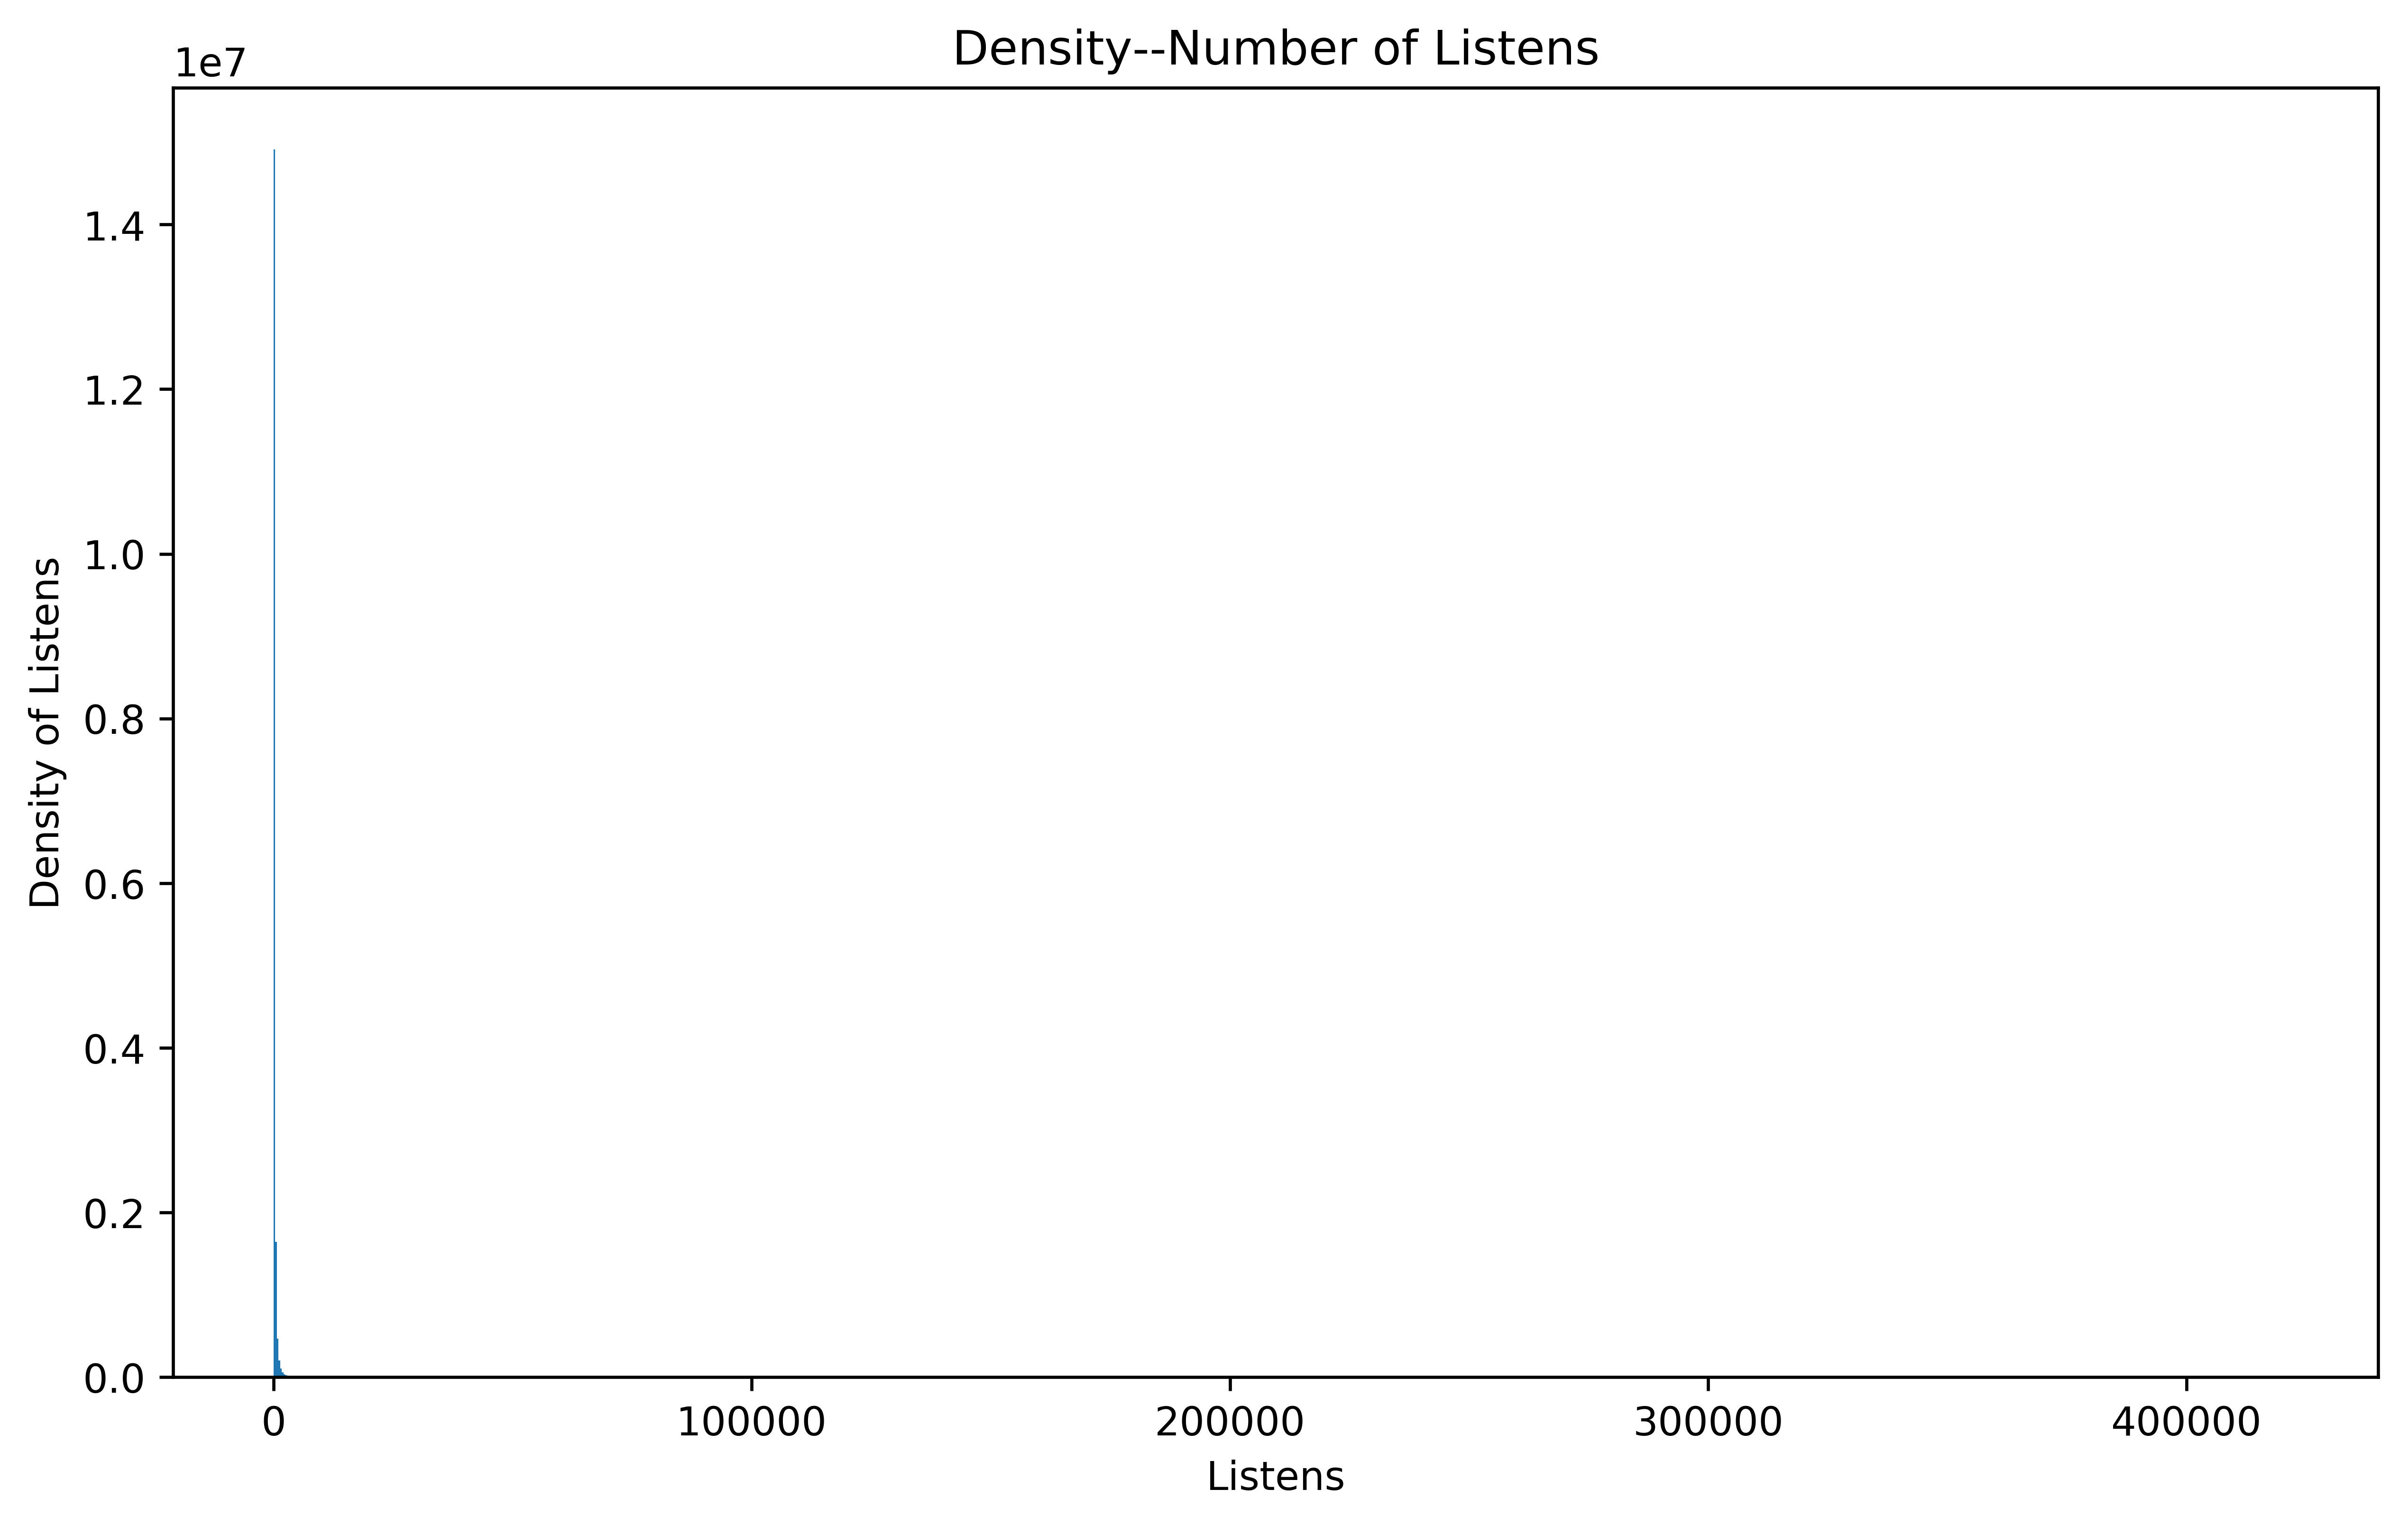

In [15]:
%matplotlib inline
plt.figure(num=40, figsize=(10, 6), dpi=600)
plt.xlabel('Listens')
plt.ylabel('Density of Listens')
plt.title("Density--Number of Listens")
plt.hist(x=listens,bins=1200,normed=False)
plt.savefig("listenDensBefore.svg")

In [109]:
#Wow. We know there's something in the 400k range. We obviously have some outliers.
# In fact, we can probably go down to 1k to catch the tail.
#However, the highest numbers should lie around the mean. We see part of what might be a curve here.
# As we trim our data closer to our mean, we should see such a curve. But how much data will we lose?

In [202]:
_RDD.map(lambda x: (float(x[4]))).stats()

(count: 17538292, mean: 215.18384218942157, stdev: 614.502116826, max: 419157.0, min: 0.0)

In [11]:
#We can see the tail is now around 2k. But really, 2k? Thats the same song 2000/365 or about 5 1/2 times a day.  
# For my puposes I am going to choose a cutoff of 700. I love music and am passionate about many artists, but
# I really dont think I even approach 700.
rdd700 = _RDD.filter(lambda x: (numberTest2(x,700)))

In [12]:
listens4 = rdd700.map(lambda x: (float(x[4]))).collect()

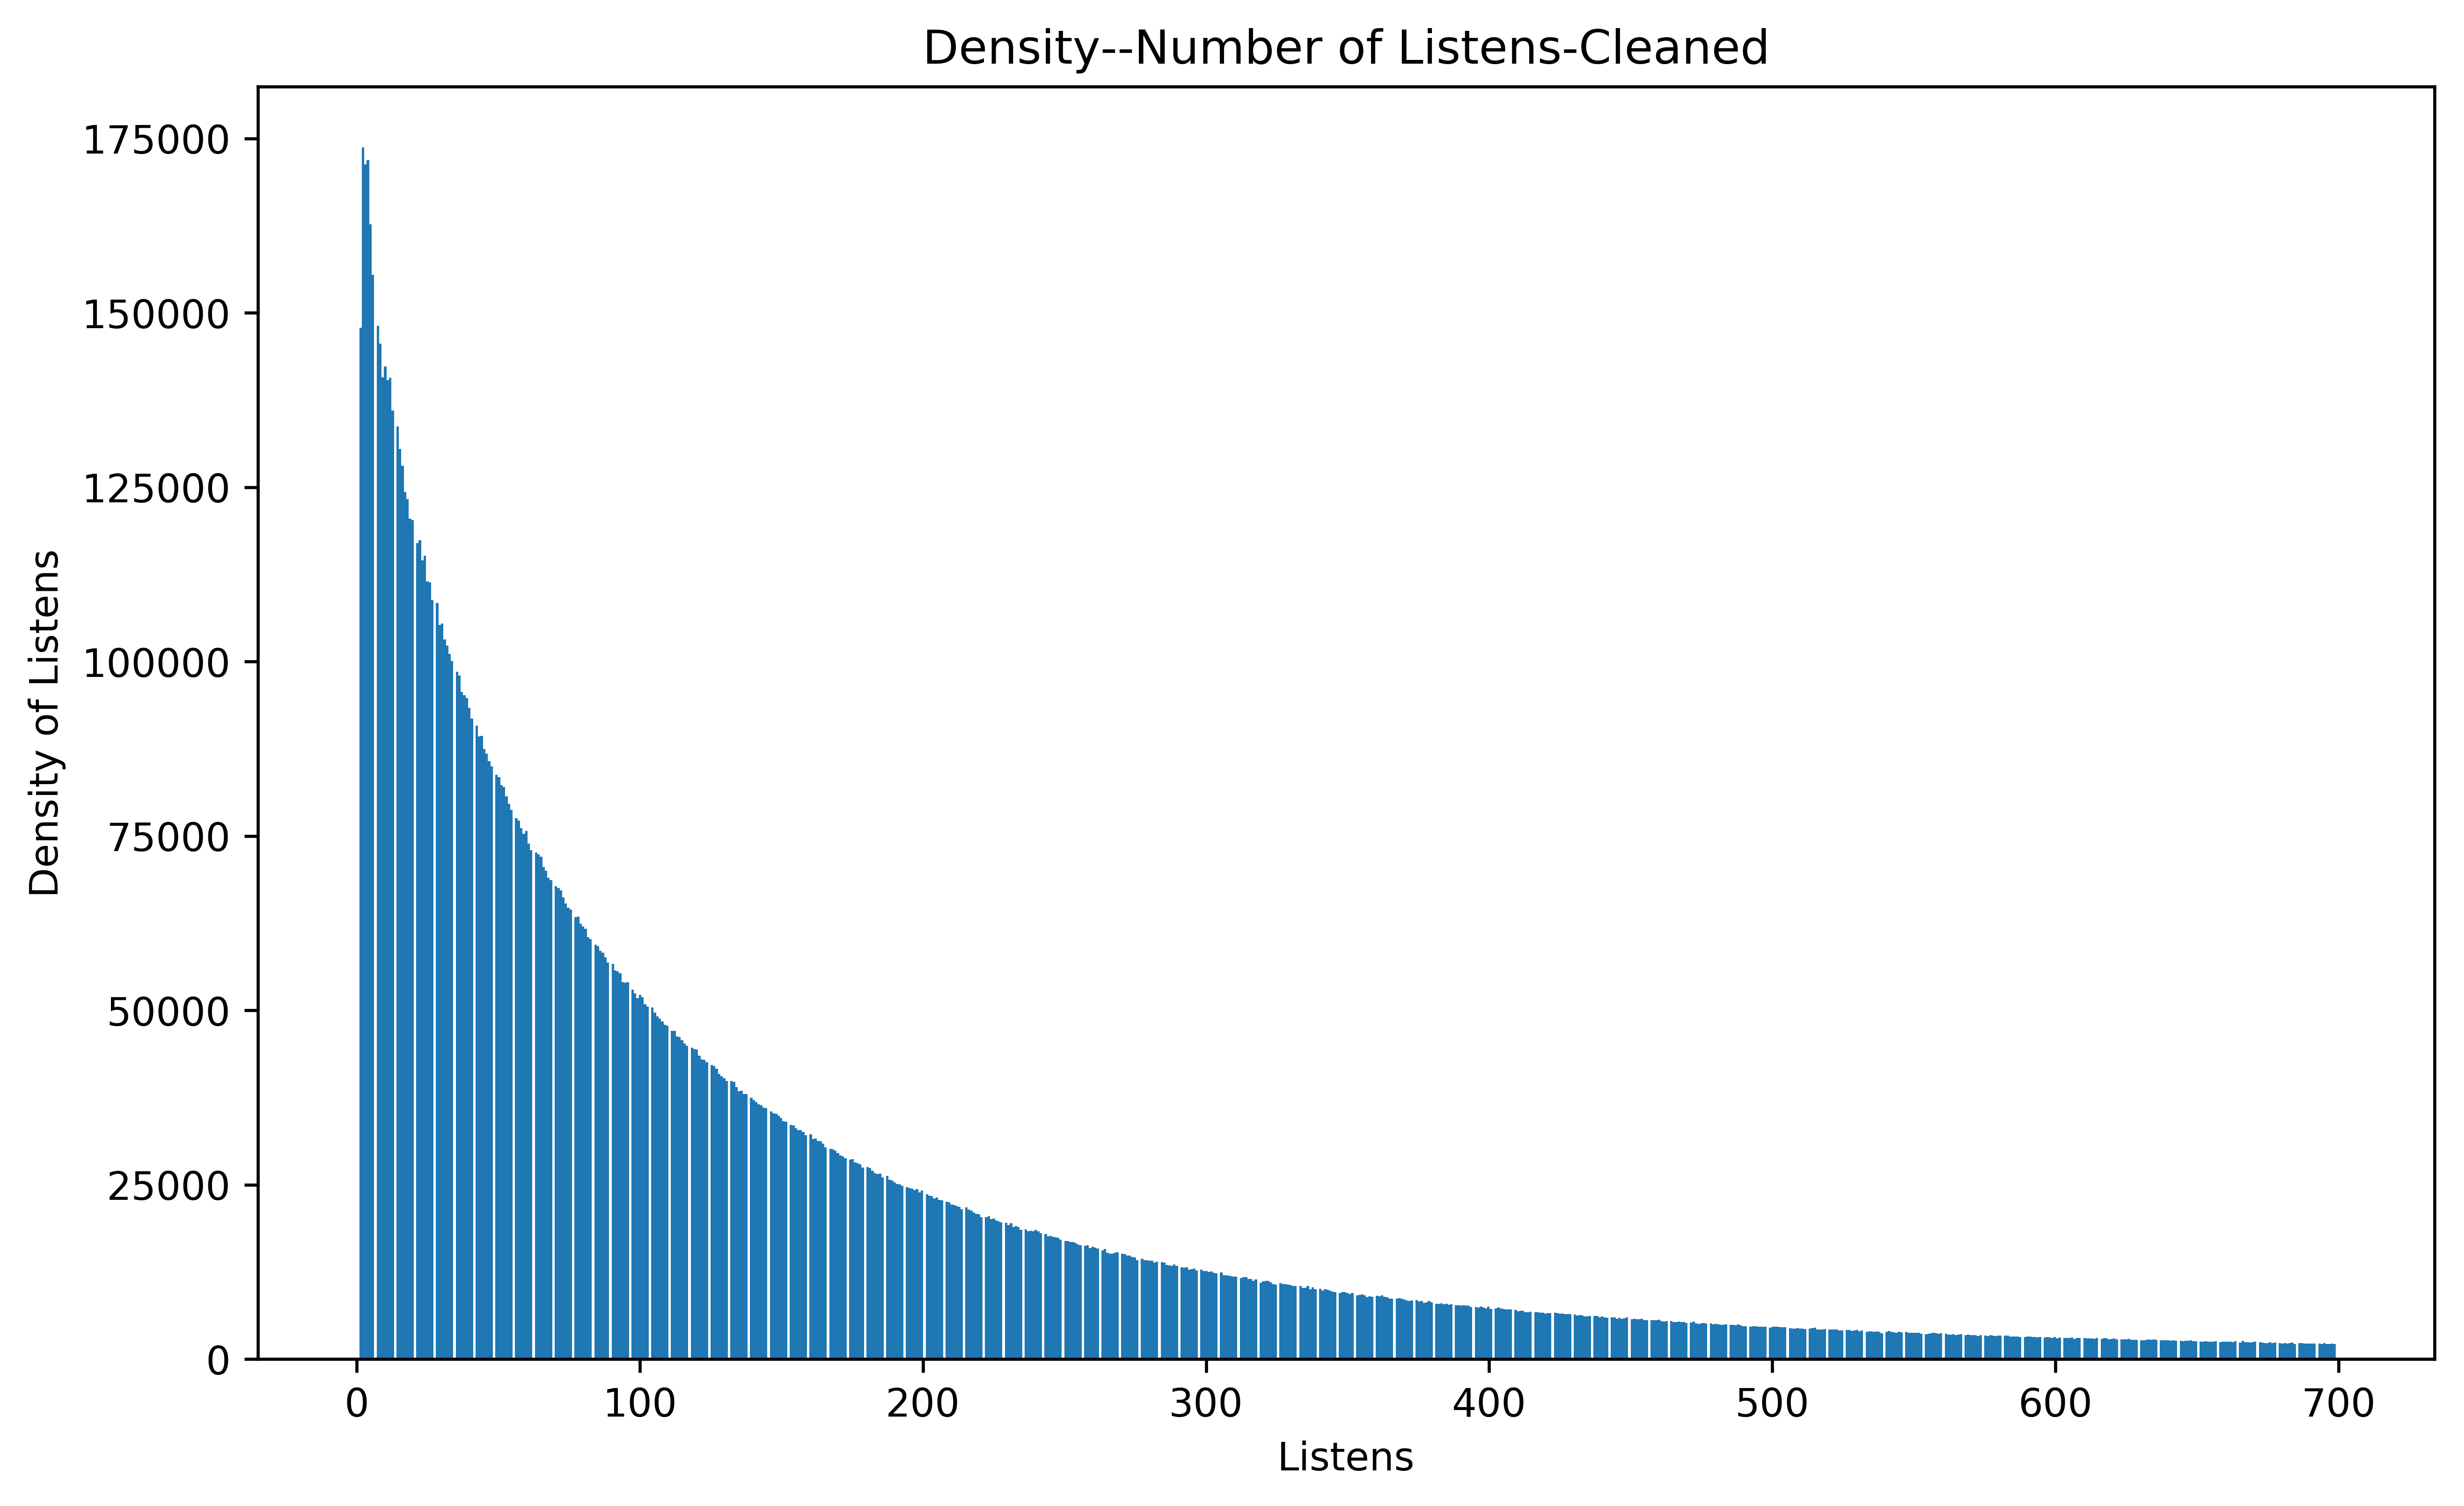

In [13]:
%matplotlib inline
plt.figure(num=400, figsize=(10, 6), dpi=600)
plt.hist(x=listens4,bins=800)
plt.xlabel('Listens')
plt.ylabel('Density of Listens')
plt.title("Density--Number of Listens-Cleaned")
plt.savefig("listenDensAfter.svg")

In [37]:
rdd700.map(lambda x: (x[2])).distinct().count()

276366

In [38]:
287646-276366

11280

In [39]:
17538290-rdd700.count()

979037

In [40]:
print('We lost a bit, but still this is only {:.3f}% of the data'.format(979037/17538290)) 

We lost a bit, but still this is only 0.056% of the data


In [41]:
rdd700.map(lambda x: (float(x[4]))).stats()

(count: 16559253, mean: 137.38360492469076, stdev: 144.717806474, max: 699.0, min: 0.0)

In [42]:
rdd700.map(lambda x: (x[3])).distinct().count()

276366

In [132]:
#We got the counts under control now, let's look at our artist listens again:

In [14]:
rated_num2 = rdd700.map(lambda x: (float(x[2]))).collect()

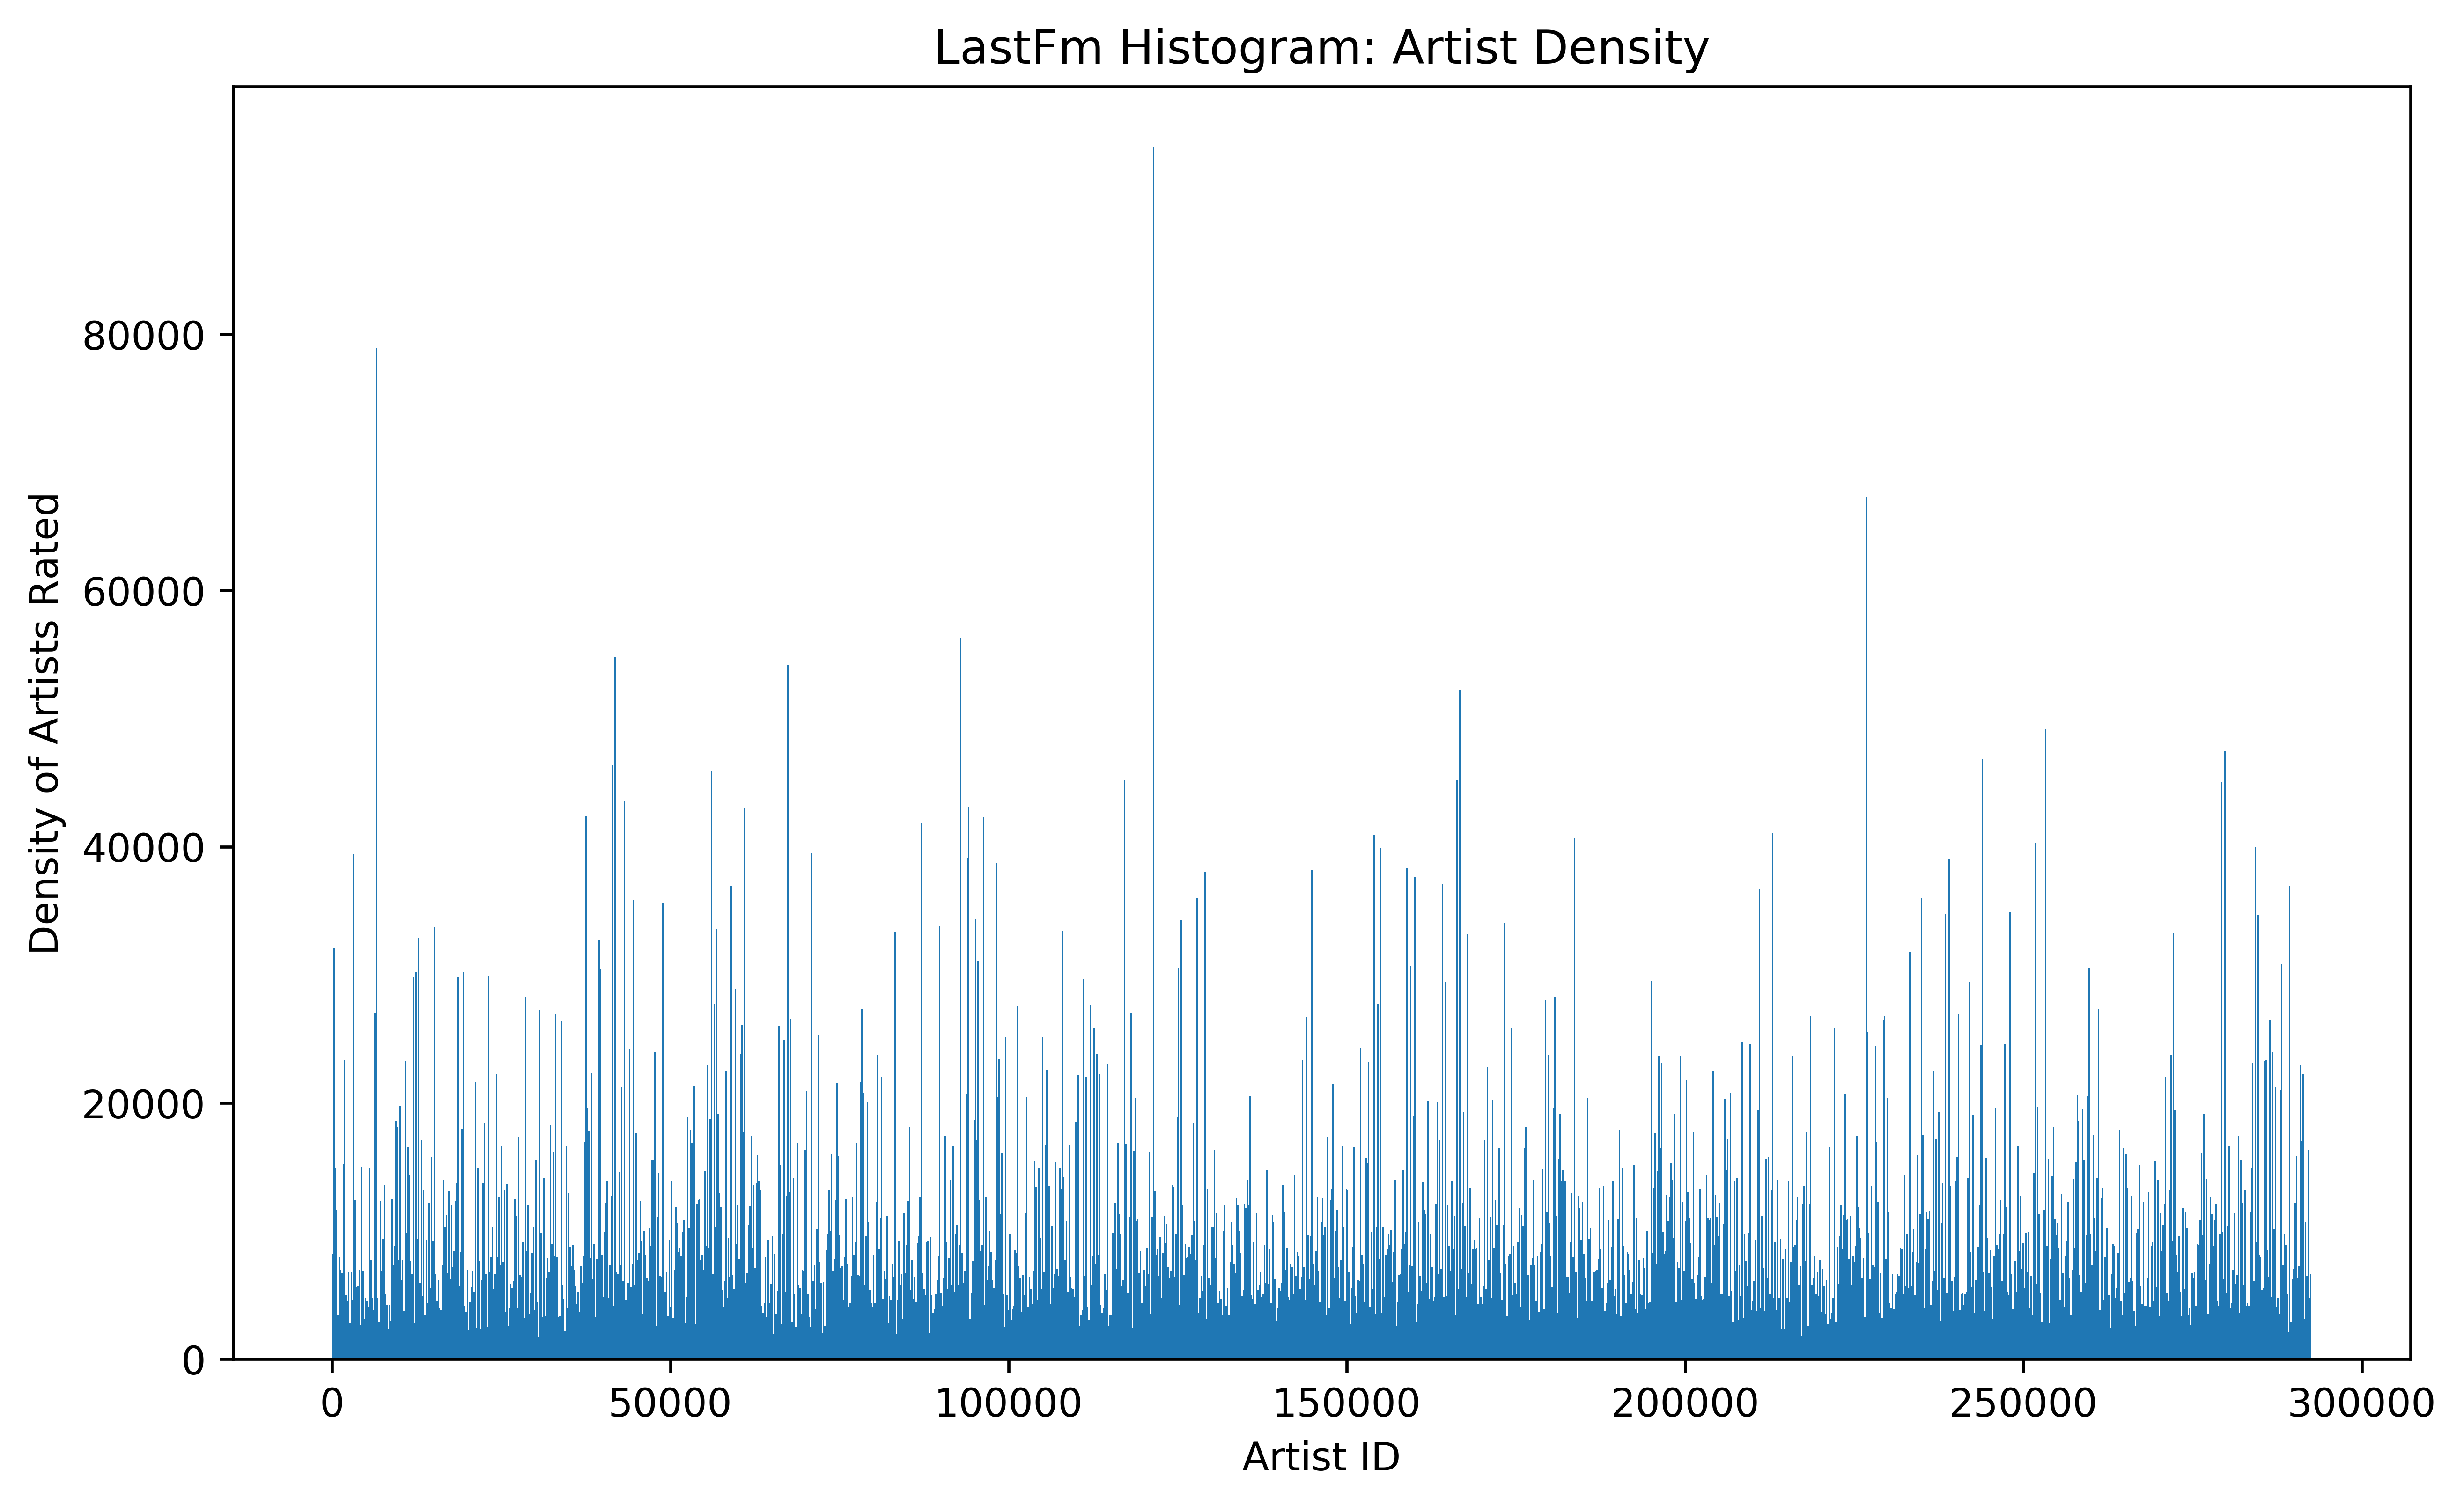

In [15]:
%matplotlib inline
x = rated_num2

plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x,bins=1500,normed=False)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')

plt.savefig('ArtDenseBefor.svg')

plt.show()

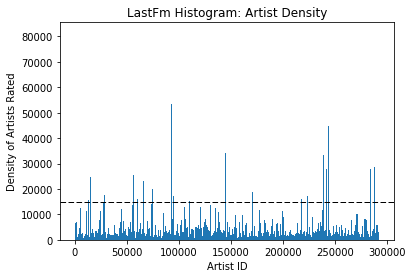

In [46]:
#It looks like 11k might be a good cutoff. Let's see how that looks
%matplotlib inline
x = rated_num2
plt.hist(x,bins=3000)
plt.axhline(15000, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density')

plt.show()

In [18]:
# To see if we should eliminate the large values or just reduce them, let's see if these are outliers or
# potentially important

In [13]:
rated_number2 = rdd700.map(lambda x: (x[2])).countByValue()

In [14]:
# Let's look at the number of times an artist is rated

rated_2 = []
for item in rated_number2.items():
    rated_2.append((item[0],item[1]))

In [14]:
len(rated_2)

276366

In [15]:
ratedRDD = sc.parallelize(rated_2)

In [16]:
ratedRDD.map(lambda x: (x[1])).stats()

(count: 276366, mean: 59.91783721586589, stdev: 654.172615955, max: 73313.0, min: 1.0)

In [16]:
#Let's take 3x the mean and see what happens to the dataset
overRatedArtists = ratedRDD.filter(lambda a: (a[1] > 180))

In [17]:
overRatedArtists.map(lambda x: (x[0])).distinct().count()

10840

In [18]:
overArtists = overRatedArtists.map(lambda x: (x[0])).collect()

In [19]:
artOverRDD = rdd700.filter(lambda x: (x[2] in overArtists))

In [20]:
artOverRDD.take(5)

[['13107200', '266493556', '207956', 'grouper', '517'],
 ['8912900', '821342251', '47688', 'bob marley', '424'],
 ['4718600', '444164354', '9388', 'jimmy eat world', '81'],
 ['524300', '717350741', '17624', 'ozzy osbourne', '74'],
 ['9437200', '893218124', '210770', 'carmen mcrae', '16']]

In [21]:
artOverRDD.count()

13836750

In [77]:
returnPerc = 1951200/13836750

In [78]:
returnPerc

0.14101577321264025

In [79]:
fract_dict = dict()
for artist in overArtists:
    fract_dict[artist] = returnPerc

In [80]:
artOverRDDIndex = artOverRDD.keyBy(lambda x: (x[2]))

In [81]:
artOverRDDIndex.take(5)

[('207956', ['13107200', '266493556', '207956', 'grouper', '517']),
 ('47688', ['8912900', '821342251', '47688', 'bob marley', '424']),
 ('9388', ['4718600', '444164354', '9388', 'jimmy eat world', '81']),
 ('17624', ['524300', '717350741', '17624', 'ozzy osbourne', '74']),
 ('210770', ['9437200', '893218124', '210770', 'carmen mcrae', '16'])]

In [82]:
sampleArtOver = artOverRDDIndex.sampleByKey(False, fract_dict, 2)

In [83]:
sampleArtOver.take(5)

[('245880', ['699100', '133877938', '245880', 'travis', '120']),
 ('17624', ['524600', '718636684', '17624', 'ozzy osbourne', '4']),
 ('268473', ['16165600', '523895916', '268473', 'autumn', '61']),
 ('13071', ['6291800', '524121978', '13071', 'pg.99', '160']),
 ('273489', ['6816100', '638636859', '273489', 'cyne', '14'])]

In [86]:
#We have all the artists
sampleArtOver.map(lambda x: (x[1][2])).distinct().count()

10840

In [87]:
sampleArt = sampleArtOver.map(lambda x: (x[1][0],x[1][1],x[1][2],x[1][3],x[1][4]))

In [88]:
sampleArt.take(5)

[('699100', '133877938', '245880', 'travis', '120'),
 ('524600', '718636684', '17624', 'ozzy osbourne', '4'),
 ('16165600', '523895916', '268473', 'autumn', '61'),
 ('6291800', '524121978', '13071', 'pg.99', '160'),
 ('6816100', '638636859', '273489', 'cyne', '14')]

In [89]:
preBalanced = rdd700.map(tuple).subtract(artOverRDD.map(tuple))

In [90]:
balancedRDD = preBalanced.union(sampleArt)

In [91]:
balancedRDD.take(5)

[('16879990', '660133657', '139067', 'the duckworth lewis method', '21'),
 ('13236122', '314772435', '225107', 'the willowz', '157'),
 ('15890768', '574428277', '164953', 'astrobrite', '66'),
 ('4562044', '428504185', '126798', 'david demaria', '4'),
 ('4077765', '328594443', '105792', 'this ascension', '7')]

In [92]:
balancedRDD.count()

4673605

In [93]:
#We lost a lot of the dataset, but was it worth it?
rated_num3 = balancedRDD.map(lambda x: (float(x[2]))).collect()

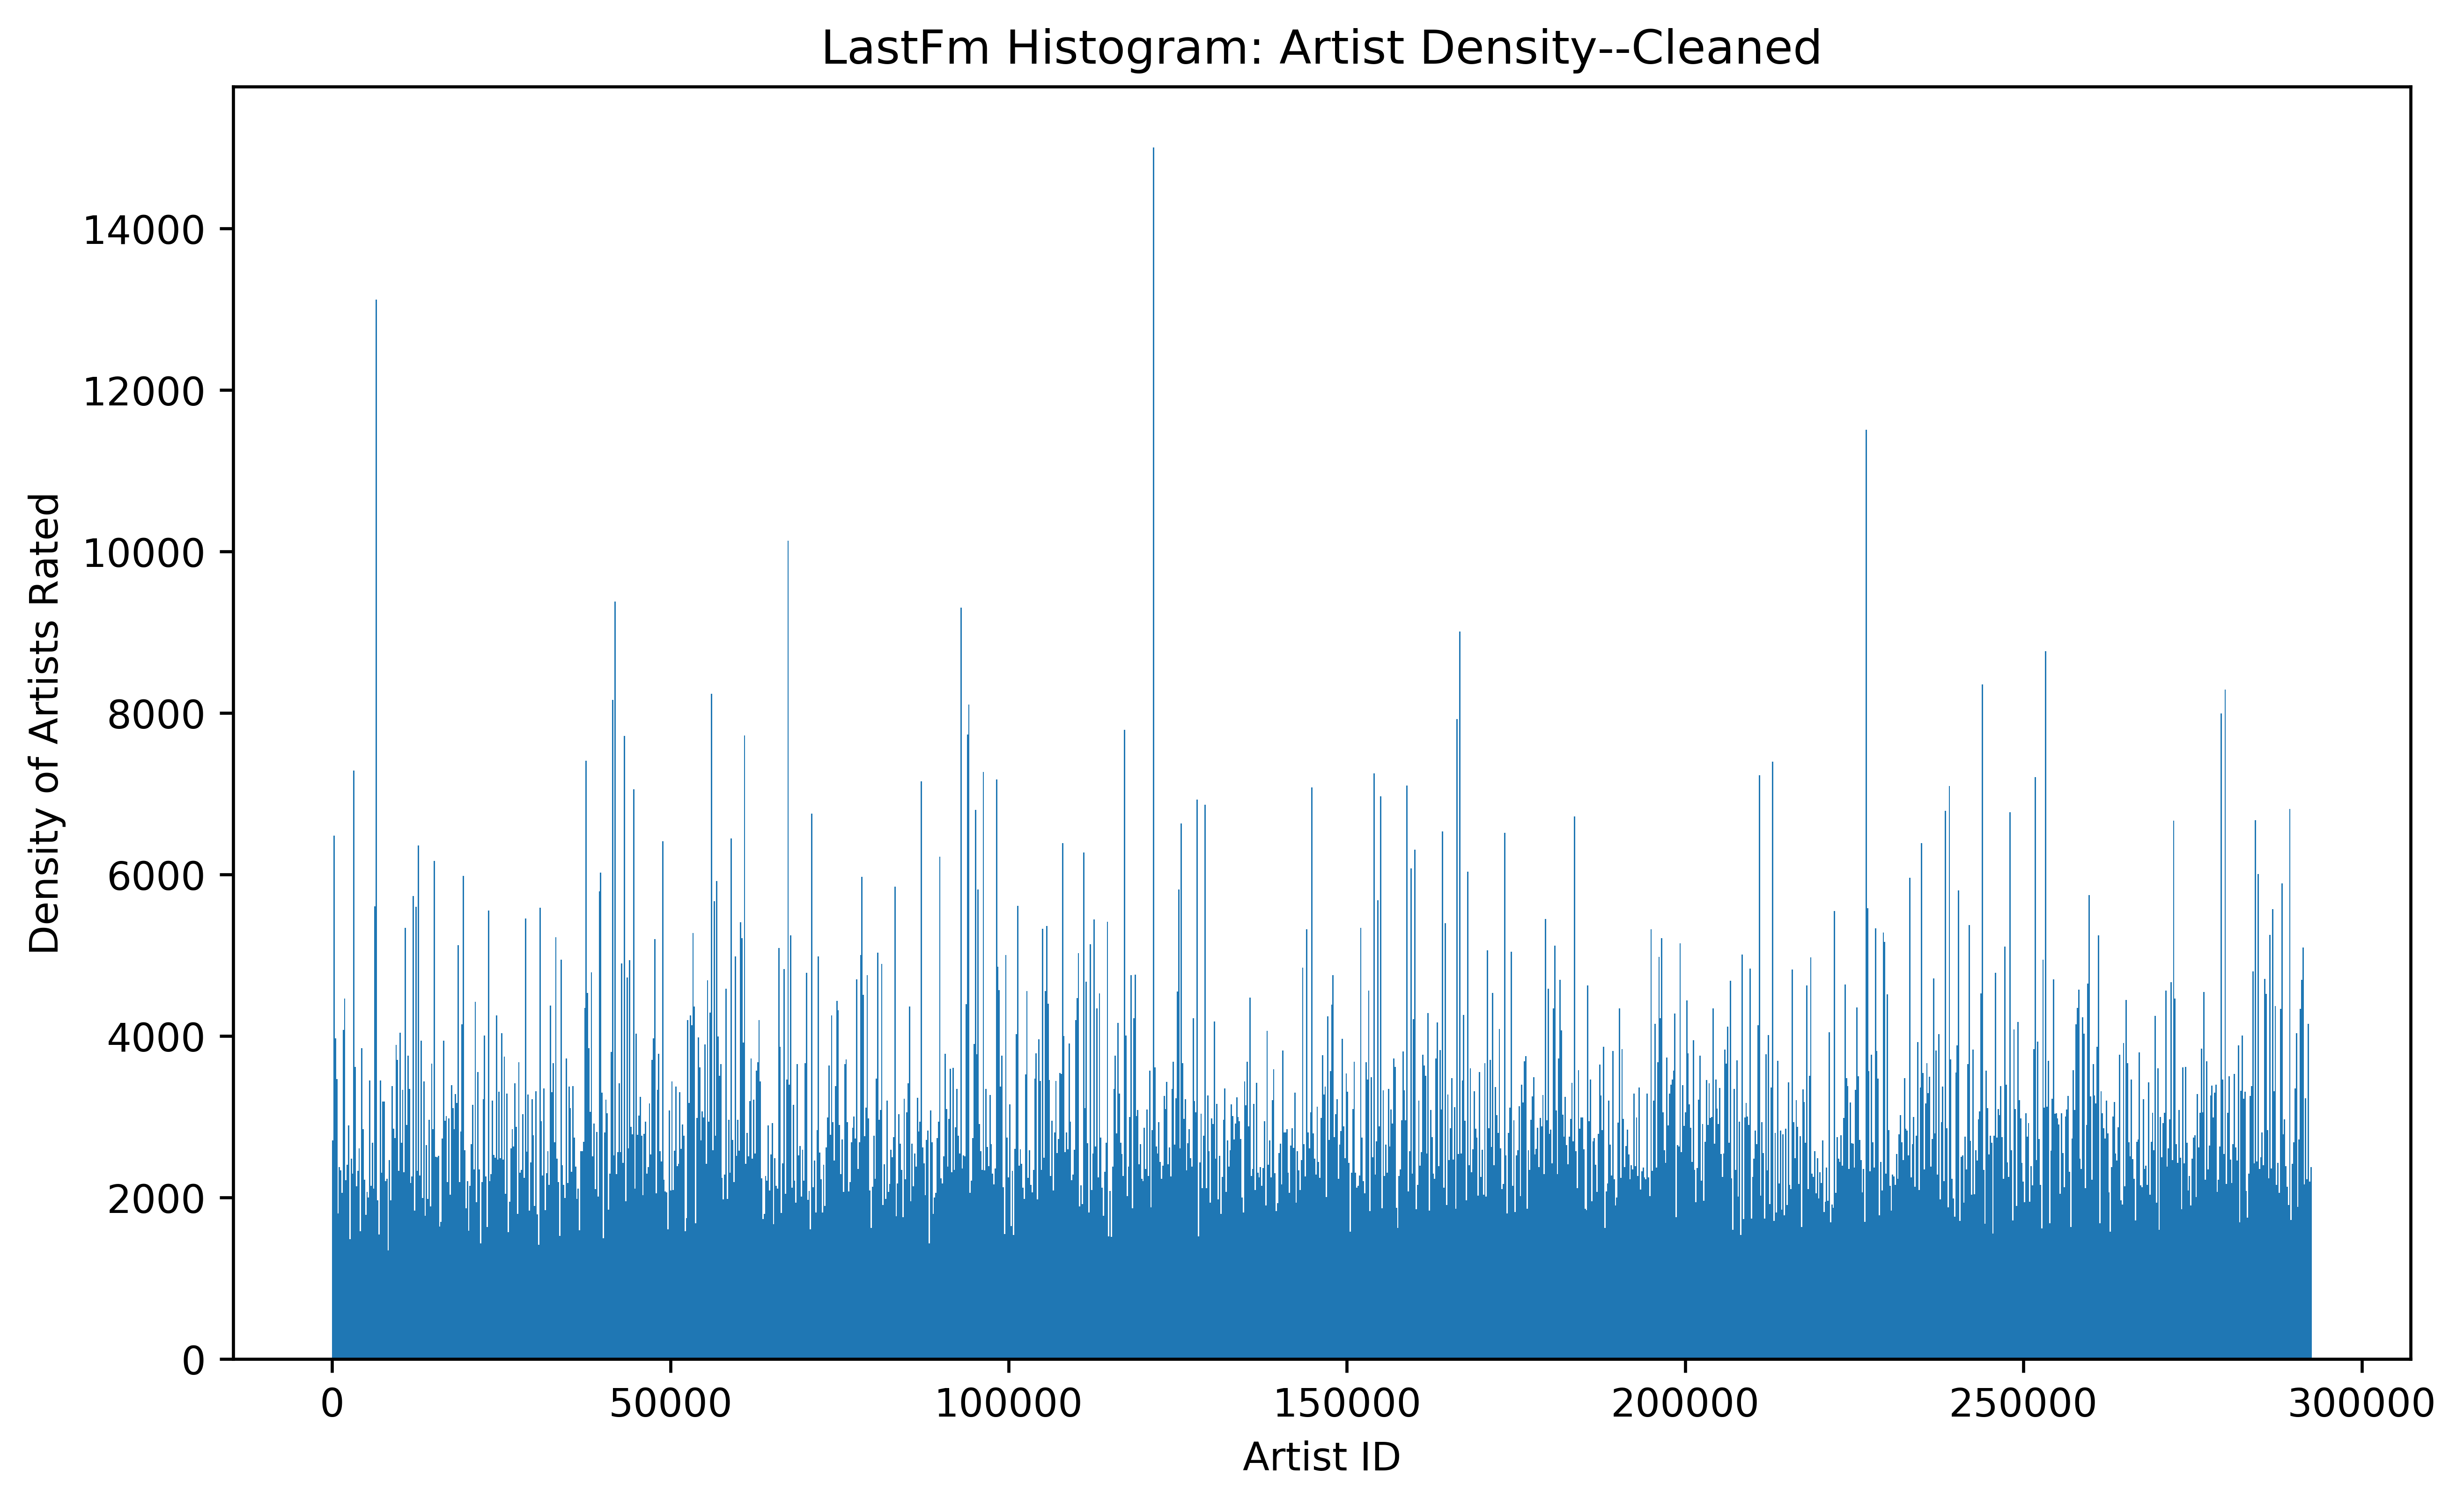

In [94]:
#rated_num3 = filteredRDD.map(lambda x: (int(x[2]))).collect()
%matplotlib inline
x = rated_num3
plt.figure(num=None, figsize=(10, 6), dpi=600)
plt.hist(x,bins=1500,normed=False)
plt.xlabel('Artist ID')
plt.ylabel('Density of Artists Rated')
plt.title('LastFm Histogram: Artist Density--Cleaned')

plt.savefig('ArtDenseBal.svg')

In [16]:
rdd_out = balancedRDD.map(lambda x: (int(x[0]),int(x[1]),int(x[2]),str(x[3]),int(x[4])))

In [17]:
rdd_out.take(5)

[(4718600, 444164354, 9388, 'jimmy eat world', 81),
 (524300, 717350741, 17624, 'ozzy osbourne', 74),
 (9437200, 893218124, 210770, 'carmen mcrae', 16),
 (5242900, 431191647, 46409, 'misery signals', 350),
 (1048600, 640712233, 99642, 'eminem', 81)]

In [18]:
import csv, io

def list_to_csv_str(x):
    """Given a list of strings, returns a properly-csv-formatted string."""
    output = io.StringIO("")
    csv.writer(output).writerow(x)
    return output.getvalue().strip() # remove extra newline

# ... do stuff with your rdd ...
rdd_out_ = rdd_out.map(list_to_csv_str)

In [19]:
rdd_out_.saveAsTextFile("hdfs://server:9000/balancedRDD.csv")